In [ ]:
import torch
import torchvision

In [ ]:
n_epochs = 300
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01

random_seed = 32
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/input/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/input/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1000, 1, 28, 28])

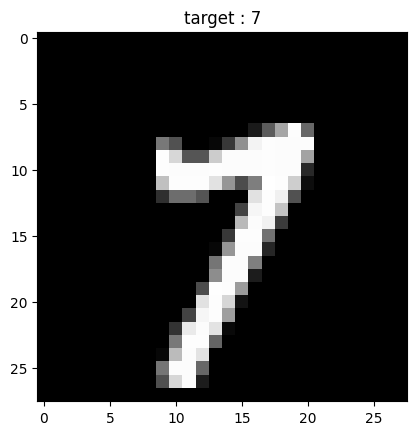

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example_data[1][0], cmap = "gray")
plt.title(f"target : {example_targets[1]}")
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.Conv1 = nn.Conv2d(1, 10, kernel_size = 5 )
    self.Conv2 = nn.Conv2d(10, 20, kernel_size = 3)
    self.Conv2_drop = nn.Dropout2d()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(500, 100)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.Conv1(x), 2))
    x = F.relu(F.max_pool2d(self.Conv2_drop(self.Conv2(x)), 2))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x))
    return x

In [ ]:
model = SimpleCNN().to("cuda")
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(n_epochs) :
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to("cuda")
    target = target.to("cuda")
    y_pred = model(data)
    loss = loss_fn(y_pred, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  if epoch%30 == 0 :
    print(f"Training Loss in epoch {epoch+ 1} is {loss}")


<ipython-input-18-abf1e1e7afbe>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc2(x))


Training Loss in epoch 1 is 0.36489471793174744
Training Loss in epoch 31 is 0.01676168106496334
Training Loss in epoch 61 is 0.011431807652115822
Training Loss in epoch 91 is 0.027208218351006508
Training Loss in epoch 121 is 0.0008296662126667798
Training Loss in epoch 151 is 0.013920590281486511
Training Loss in epoch 181 is 0.009090361185371876
Training Loss in epoch 211 is 0.006007441785186529
Training Loss in epoch 241 is 0.005623022560030222
Training Loss in epoch 271 is 0.00047037433250807226


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.7 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassAccuracy
metric = MulticlassAccuracy(num_classes=10).to("cuda")

In [ ]:
model.eval()
cummulative_loss = 0

for data, target in test_loader :
  train_acc = 0
  data = data.to("cuda")
  target = target.to("cuda")
  with torch.no_grad():
    y_pred = model(data)
    loss = loss_fn(y_pred, target)
    train_acc = metric(y_pred, target)
    print(train_acc)
    cummulative_loss += loss

# print(cummulative_loss)
# print(train_acc/ len(test_loader[1]))


<ipython-input-18-abf1e1e7afbe>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc2(x))


tensor(0.9892, device='cuda:0')
tensor(0.9921, device='cuda:0')
tensor(0.9942, device='cuda:0')
tensor(0.9939, device='cuda:0')
tensor(0.9961, device='cuda:0')
tensor(0.9960, device='cuda:0')
tensor(0.9924, device='cuda:0')
tensor(0.9897, device='cuda:0')
tensor(0.9916, device='cuda:0')
tensor(0.9918, device='cuda:0')


In [ ]:
torch.save(model.state_dict(), "model.pth")